In [1]:
import itertools
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from PathConstants import *
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# make sure tensorflow is using GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [ ]:
# function definitions
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [3]:
train_path = ORGANIZED_DATA_DIRECTORY + 'train'
valid_path = ORGANIZED_DATA_DIRECTORY + 'valid'
test_path = ORGANIZED_DATA_DIRECTORY + 'test'

In [4]:
# create Image data generator
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

In [5]:
# create batch iterators
train_batch_it = data_gen.flow_from_directory(train_path, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
valid_batch_it = data_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
test_batch_it = data_gen.flow_from_directory(test_path, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=False)

Found 16658 images belonging to 15 classes.
Found 750 images belonging to 15 classes.
Found 300 images belonging to 15 classes.


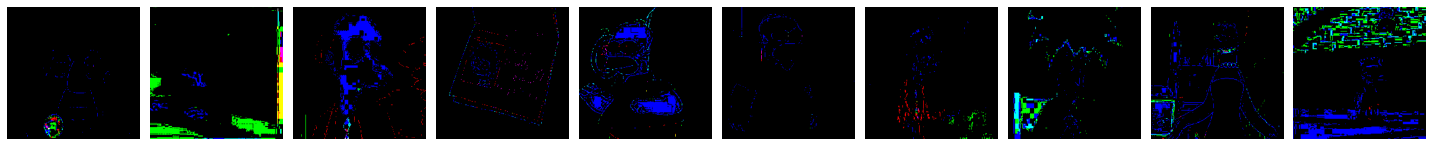

In [6]:
# display some images from training set
aug_images = [next(train_batch_it)[0][0].astype(np.uint8) for i in range(10)]
plotImages(aug_images)

In [7]:
mobile = tf.keras.applications.mobilenet.MobileNet()
x = mobile.layers[-6].output
output  = Dense(units=CLASSES_TO_WORK_WITH, activation='softmax')(x)

In [8]:
simp_model = Model(inputs=mobile.input, outputs=output)

In [9]:
for layer in simp_model.layers[:-30]:
    layer.trainable = False


In [10]:
simp_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [11]:
simp_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
print("model compiled")

model compiled


In [12]:
simp_model.fit(x=train_batch_it,
            steps_per_epoch=len(train_batch_it),
            validation_data=valid_batch_it,
            validation_steps=len(valid_batch_it),
            epochs=TRAINING_EPOCHS,
            verbose=2
)
print('model trained...')

Epoch 1/5
334/334 - 31s - loss: 0.5716 - accuracy: 0.8463 - val_loss: 0.2072 - val_accuracy: 0.9493
Epoch 2/5
334/334 - 30s - loss: 0.1022 - accuracy: 0.9796 - val_loss: 0.1253 - val_accuracy: 0.9693
Epoch 3/5
334/334 - 31s - loss: 0.0367 - accuracy: 0.9967 - val_loss: 0.0998 - val_accuracy: 0.9747
Epoch 4/5
334/334 - 30s - loss: 0.0156 - accuracy: 0.9990 - val_loss: 0.1028 - val_accuracy: 0.9747
Epoch 5/5
334/334 - 30s - loss: 0.0084 - accuracy: 0.9996 - val_loss: 0.0975 - val_accuracy: 0.9747
model trained...


In [13]:
import os.path
if not os.path.isfile('models/simp_model.h5'):
    simp_model.save('models/simp_model.h5')
    print("model saved")

In [14]:
# get test labels for testing
test_labels = test_batch_it.classes

In [15]:
predictions = simp_model.predict(test_batch_it)
# create confusion matrix for result visualization
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
# print correct answers
test_batch_it.class_indices

{'abraham_grampa_simpson': 0,
 'apu_nahasapeemapetilon': 1,
 'bart_simpson': 2,
 'charles_montgomery_burns': 3,
 'chief_wiggum': 4,
 'homer_simpson': 5,
 'kent_brockman': 6,
 'krusty_the_clown': 7,
 'lisa_simpson': 8,
 'marge_simpson': 9,
 'milhouse_van_houten': 10,
 'moe_szyslak': 11,
 'ned_flanders': 12,
 'principal_skinner': 13,
 'sideshow_bob': 14}

In [16]:
# define labels for the plot
cm_plot_labels = NAME_LABELS


Confusion matrix, without normalization
[[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 19  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0 19  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0 19  0  0  0]
 [ 0  0  0  0  0  1  0  1  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 19  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0 19]]


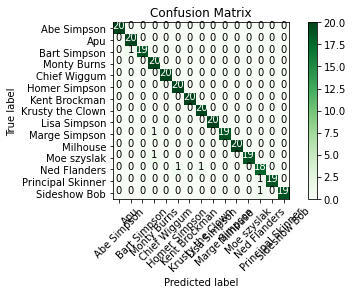

In [18]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [19]:
# save model to file
#simp_model.save('models/simp_model.h5')
